## Preprocess data to get training and testing data

In [1]:
# Import package
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft 
from scipy import signal
# from biosppy.signals import ecg
import neurokit2 as nk
from sklearn import *
from collections import OrderedDict

In [2]:
#Set the read file path
path = '/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/'

X = np.load(path + 'raw100.npy', allow_pickle=True)
sampling_rate = 100

In [3]:
X.shape

(21801, 1000, 12)

In [4]:
import numpy as np

# Extracting values from the second column (Lead 2)
X2 = X[:, :, 1]


In [6]:
# Read the file and convert tags
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [5]:
X2.shape

(21801, 1000)

In [7]:
# Get diagnostic information in scp_statements.csv
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

In [8]:
agg_df = agg_df[agg_df.diagnostic == 1]

In [9]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in agg_df.index:
            res.add(agg_df.loc[k].diagnostic_class)
    return list(res)

In [10]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [11]:
Y['scp_classes'] = Y.scp_codes.apply(diagnostic_class)

In [13]:
Z = pd.DataFrame(0, index=Y.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in Y.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


In [14]:
#Add diagnostic information
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [15]:
Y.diagnostic_superclass.value_counts()

diagnostic_superclass
[NORM]                 9072
[MI]                   2532
[STTC]                 2401
[CD]                   1708
[CD, MI]               1300
[STTC, HYP]             781
[STTC, MI]              600
[HYP]                   535
[CD, STTC]              471
[CD, NORM]              407
[]                      405
[STTC, HYP, MI]         361
[CD, HYP]               300
[CD, STTC, MI]          223
[CD, STTC, HYP]         211
[HYP, MI]               183
[CD, STTC, HYP, MI]     156
[CD, HYP, MI]           117
[STTC, NORM]             28
[CD, STTC, NORM]          5
[CD, HYP, NORM]           2
[HYP, NORM]               2
[CD, MI, HYP, NORM]       1
Name: count, dtype: int64

In [16]:
unique_values = Y['diagnostic_superclass'].apply(tuple).unique()
print(unique_values)


[('NORM',) ('MI',) () ('STTC',) ('HYP',) ('CD',) ('STTC', 'MI')
 ('CD', 'HYP') ('CD', 'MI') ('CD', 'STTC') ('HYP', 'MI')
 ('STTC', 'HYP', 'MI') ('CD', 'STTC', 'HYP', 'MI') ('STTC', 'HYP')
 ('CD', 'NORM') ('CD', 'STTC', 'MI') ('CD', 'STTC', 'HYP')
 ('STTC', 'NORM') ('CD', 'HYP', 'MI') ('CD', 'STTC', 'NORM')
 ('CD', 'HYP', 'NORM') ('HYP', 'NORM') ('CD', 'MI', 'HYP', 'NORM')]


In [17]:
# Split data into train and test
test_fold = 10
# # Train
X_train = X2[(Y.strat_fold <= 8)]
# y_train = Z[Y.strat_fold <= 8]
y_train = Y[(Y.strat_fold <= 8)].diagnostic_superclass
# # Test
X_test = X2[(Y.strat_fold >8)]
# y_test = Z[Y.strat_fold > 8]
y_test = Y[(Y.strat_fold > 8)].diagnostic_superclass


print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(17420, 1000) (17420,)
(4381, 1000) (4381,)


In [19]:
save_path = '/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/data/lead2/'

np.save(save_path+'x_train.npy', X_train)
np.save(save_path+'y_train.npy', np.array(y_train))
np.save(save_path+'x_test.npy', X_test)
np.save(save_path+'y_test.npy', np.array(y_test))

## ECG SHaP starts

In [1]:
from tensorflow.keras import layers, optimizers, losses, metrics, activations, regularizers, callbacks
from keras.models import Model
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM

2024-02-20 10:30:29.814196: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 10:30:29.814240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 10:30:29.815133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 10:30:30.019007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 10:30:32.450453: W tensorflow/c

In [2]:
path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/data/lead2/"
x_train = np.load(path + 'x_train.npy')
y_train = np.load(path + 'y_train.npy', allow_pickle=True)
x_test  = np.load(path + 'x_test.npy')
y_test  = np.load(path + 'y_test.npy', allow_pickle=True)
print(x_train.shape)
print(x_test.shape)

(17420, 1000)
(4381, 1000)


In [3]:
x_train = x_train.reshape((17420, 1000, 1))
x_test = x_test.reshape((4381, 1000, 1))
print(x_train.shape)
print(x_test.shape)

(17420, 1000, 1)
(4381, 1000, 1)


In [4]:
x_train = x_train.transpose(0, 2, 1)            # transpose working correctly
x_test  = x_test.transpose(0, 2, 1)
print(x_train.shape)
print(x_test.shape)

(17420, 1, 1000)
(4381, 1, 1000)


In [5]:
x_train = x_train.reshape(17420, 1, 1000, 1)   # Add another channel
x_test  = x_test.reshape(4381, 1, 1000, 1)

In [6]:
print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_test  :", x_test.shape)
print("y_test  :", y_test.shape)
print('Data loaded')

# Old OUTPUTS:
# (19601, 1000, 12)
# (19601, 12, 1000)
# x_train : (19601, 12, 1000, 1)
# y_train : (19601,)
# x_test  : (2198, 12, 1000, 1)
# y_test  : (2198,)
# Data loaded

x_train : (17420, 1, 1000, 1)
y_train : (17420,)
x_test  : (4381, 1, 1000, 1)
y_test  : (4381,)
Data loaded


In [7]:
# x_train = x_train[:2000]
# x_test = x_test[:500]
# y_train = y_train[:2000]
# y_test = y_test[:500]

In [8]:
print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_test  :", x_test.shape)
print("y_test  :", y_test.shape)
print('Data loaded')

x_train : (17420, 1, 1000, 1)
y_train : (17420,)
x_test  : (4381, 1, 1000, 1)
y_test  : (4381,)
Data loaded


In [9]:

from sklearn.preprocessing import MultiLabelBinarizer
# Convert multi-label target labels to one-hot encoded matrix
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
print("Classes:", mlb.classes_)

Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC']


In [10]:
y_test.shape

(4381, 5)

In [11]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

# Main Version
input = layers.Input(shape=(1, 1000, 1))

X = layers.Conv2D(filters=32, kernel_size=(1, 5))(input)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.MaxPooling2D(pool_size=(1, 2), strides=1)(X)

convC1 = layers.Conv2D(filters=64, kernel_size=(1, 7))(X)

X = layers.Conv2D(filters=32, kernel_size=(1, 5))(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.MaxPooling2D(pool_size=(1, 4), strides=1)(X)

convC2 = layers.Conv2D(filters=64, kernel_size=(1, 6))(convC1)

X = layers.Conv2D(filters=64, kernel_size=(1, 5))(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([convC2, X])           # skip Connection
X = layers.ReLU()(X)
X = layers.MaxPooling2D(pool_size=(1, 2), strides=1)(X)

convE1 = layers.Conv2D(filters=32, kernel_size=(1, 4))(X)

X = layers.Conv2D(filters=64, kernel_size=(1, 3))(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.MaxPooling2D(pool_size=(1, 4), strides=1)(X)

convE2 = layers.Conv2D(filters=64, kernel_size=(1, 5))(convE1)

X = layers.Conv2D(filters=64, kernel_size=(1, 3))(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([convE2, X])         # skip Connection
X = layers.ReLU()(X)
X = layers.MaxPooling2D(pool_size=(1, 2), strides=1)(X)
print('Added 5 layers for temporal analysis')

# Modify this convolution layer to include 'same' padding
X = layers.Conv2D(filters=64, kernel_size=(12, 1), padding='same')(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.GlobalAveragePooling2D()(X)
print('Added 1 layer for spatial Analysis')

X = layers.Flatten()(X)
print(X.shape)

X = layers.Dense(units=128, kernel_regularizer=regularizers.L2(0.005))(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.Dropout(rate=0.1)(X)

X = layers.Dense(units=64, kernel_regularizer=regularizers.L2(0.009))(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.Dropout(rate=0.15)(X)
print('Added 2 fully connected layers')

output = layers.Dense(5, activation='sigmoid')(X)
model = Model(inputs=input, outputs=output)
print(model.summary())


2024-02-20 10:30:43.043247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13718 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5


Added 5 layers for temporal analysis
Added 1 layer for spatial Analysis
(None, 64)
Added 2 fully connected layers
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 1000, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1, 996, 32)           192       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1, 996, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                               

In [12]:
# Source: https://keras.io/api/callbacks/
# Source: https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6

early    = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
reducelr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)
callback = [early, reducelr]

model.compile(optimizer = optimizers.Adam(learning_rate=0.005),
              loss = losses.BinaryCrossentropy(),
              metrics = [metrics.BinaryAccuracy(), metrics.AUC(curve='ROC', multi_label=True)])

history = model.fit(x_train, y_train, validation_split=0.12, epochs=20, batch_size=64, callbacks=callback)

Epoch 1/20


2024-02-20 10:30:52.824709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-02-20 10:30:53.243507: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-20 10:30:53.986457: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-20 10:30:56.799405: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15514413fa70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 10:30:56.799444: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-02-20 10:30:56.883323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-20 10:30:57.048032: I ./tensorflow/compiler/jit/device_compiler.h:186] Com

240/240 [==============================] - 25s 43ms/step - loss: 0.5880 - binary_accuracy: 0.7977 - auc: 0.7531 - val_loss: 0.5991 - val_binary_accuracy: 0.7401 - val_auc: 0.6528 - lr: 0.0050
Epoch 2/20
240/240 [==============================] - 9s 36ms/step - loss: 0.4458 - binary_accuracy: 0.8192 - auc: 0.7967 - val_loss: 0.6586 - val_binary_accuracy: 0.6709 - val_auc: 0.6770 - lr: 0.0050
Epoch 3/20
240/240 [==============================] - 9s 36ms/step - loss: 0.4319 - binary_accuracy: 0.8242 - auc: 0.8076 - val_loss: 0.5000 - val_binary_accuracy: 0.7767 - val_auc: 0.7820 - lr: 0.0050
Epoch 4/20
240/240 [==============================] - 9s 36ms/step - loss: 0.4254 - binary_accuracy: 0.8261 - auc: 0.8108 - val_loss: 0.5269 - val_binary_accuracy: 0.7548 - val_auc: 0.7561 - lr: 0.0050
Epoch 5/20
240/240 [==============================] - 9s 36ms/step - loss: 0.4201 - binary_accuracy: 0.8293 - auc: 0.8157 - val_loss: 0.4954 - val_binary_accuracy: 0.7843 - val_auc: 0.7672 - lr: 0.0050


In [13]:
save_path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/"
model.save(save_path + "ST-CNN-5_lead2.h5")

/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Assuming you have a trained model 'model'
# Make predictions on the test set
y_pred = model.predict(x_test)

# Assuming y_pred is in the probability format (values between 0 and 1)
# Convert the probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Convert the binary predictions back to class labels using MultiLabelBinarizer
predicted_classes = mlb.inverse_transform(y_pred_binary)

# Display the predicted classes for the first few samples
for i in range(5):
    print(f"Sample {i + 1}: Predicted Classes - {predicted_classes[i]}")


137/137 [==============================] - 1s 8ms/step
Sample 1: Predicted Classes - ('NORM',)
Sample 2: Predicted Classes - ('NORM',)
Sample 3: Predicted Classes - ('NORM',)
Sample 4: Predicted Classes - ()
Sample 5: Predicted Classes - ()


In [15]:
# Assuming you have a trained model 'model'
# Make predictions on the test set
y_pred = model.predict(x_test)

# Assuming y_pred is in the probability format (values between 0 and 1)
# Convert the probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Convert the binary predictions back to class labels using MultiLabelBinarizer
predicted_classes = mlb.inverse_transform(y_pred_binary)

# Use a set to accumulate all distinct classes
distinct_classes = set()

# Iterate over predicted classes and add them to the set
for classes in predicted_classes:
    distinct_classes.update(classes)

# Display all distinct classes
print("All Distinct Classes:", distinct_classes)


137/137 [==============================] - 1s 6ms/step
All Distinct Classes: {'CD', 'NORM', 'STTC', 'MI', 'HYP'}


In [16]:
from tensorflow.keras.models import load_model
model = load_model(r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_lead2.h5')
y_pred_train = model.predict(x_train)
y_pred_test  = model.predict(x_test)

137/137 [==============================] - 1s 6ms/step


In [17]:
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, roc_auc_score, accuracy_score, auc
import numpy as np

def sklearn_metrics(y_true, y_pred, mlb):
    y_bin = np.copy(y_pred)
    y_bin[y_bin >= 0.5] = 1
    y_bin[y_bin < 0.5]  = 0

    # Compute area under precision-Recall curve
    auc_sum = 0
    for i in range(y_true.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        auc_sum += auc(recall, precision)

    print("Accuracy        : {:.2f}".format(accuracy_score(y_true.flatten(), y_bin.flatten()) * 100))
    print("Macro AUC score : {:.2f}".format(roc_auc_score(y_true, y_pred, average='macro') * 100))
    print('AUROC           : {:.2f}'.format((auc_sum / y_true.shape[1]) * 100))
    print("Micro F1 score  : {:.2f}".format(f1_score(y_true, y_bin, average='micro') * 100))

    # Convert binary predictions back to class labels using MultiLabelBinarizer
    predicted_classes = mlb.inverse_transform(y_bin)

    # Use a set to accumulate all distinct classes
    distinct_classes = set()

    # Iterate over predicted classes and add them to the set
    for classes in predicted_classes:
        distinct_classes.update(classes)

    # Convert the set of distinct classes to a sorted list
    class_names = sorted(list(distinct_classes))

    # Print classification report for each class
    print("\nClassification Report:")
    print(classification_report(y_true, y_bin, target_names=class_names))

# Assuming mlb is the MultiLabelBinarizer used for transforming the labels
sklearn_metrics(y_test, y_pred_test, mlb)


Accuracy        : 84.43
Macro AUC score : 85.06
AUROC           : 66.54
Micro F1 score  : 65.49

Classification Report:
              precision    recall  f1-score   support

          CD       0.80      0.55      0.65       992
         HYP       0.68      0.10      0.18       530
          MI       0.71      0.37      0.49      1092
        NORM       0.76      0.87      0.81      1919
        STTC       0.72      0.53      0.61      1049

   micro avg       0.75      0.58      0.65      5582
   macro avg       0.73      0.49      0.55      5582
weighted avg       0.74      0.58      0.62      5582
 samples avg       0.67      0.61      0.63      5582



/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


137/137 [==============================] - 1s 5ms/step


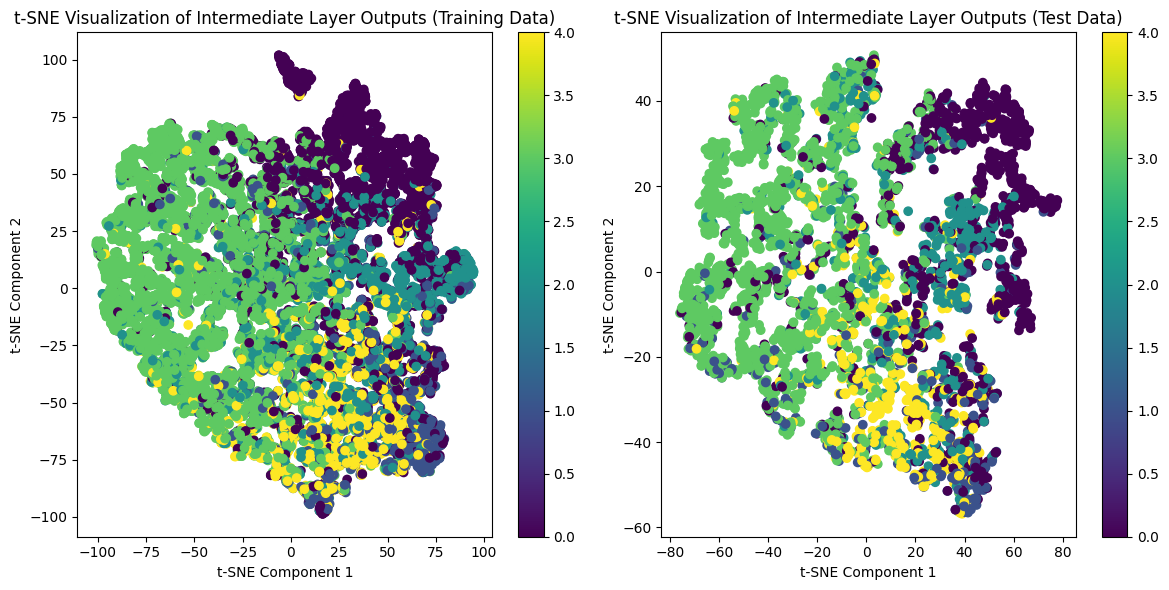

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model

# Load the saved model
saved_model_path = r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_lead2.h5'
model = load_model(saved_model_path)

# Define a function to extract intermediate layer outputs
def extract_intermediate_outputs(model, data):
    intermediate_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    intermediate_output = intermediate_model.predict(data)
    return intermediate_output

# Extract intermediate layer outputs for both training and test data
intermediate_output_train = extract_intermediate_outputs(model, x_train)
intermediate_output_test = extract_intermediate_outputs(model, x_test)

# Apply t-SNE to intermediate layer outputs for both training and test data
tsne_train = TSNE(n_components=2, random_state=42)
tsne_output_train = tsne_train.fit_transform(intermediate_output_train)

tsne_test = TSNE(n_components=2, random_state=42)
tsne_output_test = tsne_test.fit_transform(intermediate_output_test)

# Plot the results for both training and test data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(tsne_output_train[:, 0], tsne_output_train[:, 1], c=y_train.argmax(axis=1), cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Intermediate Layer Outputs (Training Data)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.subplot(1, 2, 2)
plt.scatter(tsne_output_test[:, 0], tsne_output_test[:, 1], c=y_test.argmax(axis=1), cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Intermediate Layer Outputs (Test Data)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()


137/137 [==============================] - 1s 6ms/step


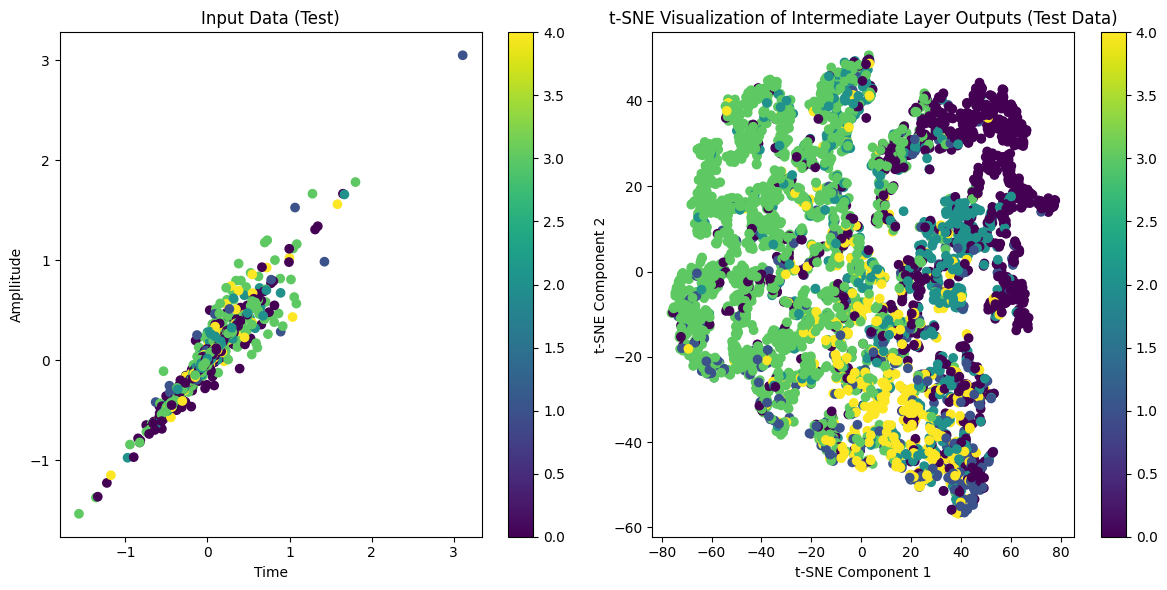

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model

# Load the saved model
saved_model_path = r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_lead2.h5'
model = load_model(saved_model_path)

# Define a function to extract intermediate layer outputs
def extract_intermediate_outputs(model, data):
    intermediate_model = Model(inputs=model.input, outputs=model.layers[-3].output)  # Output right before the output layer
    intermediate_output = intermediate_model.predict(data)
    return intermediate_output

# Extract intermediate layer outputs for the test data
intermediate_output_test = extract_intermediate_outputs(model, x_test)

# Apply t-SNE to intermediate layer outputs for the test data
tsne = TSNE(n_components=2, random_state=42)
tsne_output_test = tsne.fit_transform(intermediate_output_test)

# Plot the results for the test data
plt.figure(figsize=(12, 6))

# Plot input data
plt.subplot(1, 2, 1)
# Flatten the input data to have the same size as y_test
x_test_flattened = x_test.reshape(x_test.shape[0], -1)
plt.scatter(x_test_flattened[:, 0], x_test_flattened[:, 1], c=y_test.argmax(axis=1), cmap='viridis')
plt.colorbar()
plt.title('Input Data (Test)')
plt.xlabel('Time')
plt.ylabel('Ampllitude')

# Plot intermediate layer outputs right before the output layer
plt.subplot(1, 2, 2)
plt.scatter(tsne_output_test[:, 0], tsne_output_test[:, 1], c=y_test.argmax(axis=1), cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Intermediate Layer Outputs (Test Data)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()


In [20]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 1000, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1, 996, 32)           192       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1, 996, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 1, 996, 32)           0         ['batch_normalization[0][0